In [1]:
import numpy as np
import gym
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
from mpl_toolkits.mplot3d import Axes3D
from collections import deque
from sklearn.kernel_approximation import RBFSampler
import sklearn.pipeline
import sklearn.preprocessing

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [2]:
env = gym.make('MountainCar-v0')
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf0", RBFSampler(gamma=5.0, n_components = 100)),
    ("rbf1", RBFSampler(gamma=2.0, n_components = 100)),
    ("rbf2", RBFSampler(gamma=1.0, n_components = 100)),
    ("rbf3", RBFSampler(gamma=0.5, n_components = 100)),
    ])
featurizer.fit(scaler.transform(observation_examples))


def featurize(state):
    try:
        scaled = scaler.transform([state])
    except:
        print(state)
    featurized = featurizer.transform(scaled)
    return featurized

In [3]:
def sarsa_lambda(nb_episodes, alpha, _lambda):
    # alpha = 0.0001
    gamma = 1
    # _lambda = 0.0
    epsilon = 0.15
    #nb_episodes = 100

    env = gym.make('MountainCar-v0')

    state = env.reset()
    norm_state = featurize(state)
    input_dim = len(norm_state[0])


    # define ANN topology
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='linear'))

    mse = tf.keras.losses.MeanSquaredError()
    opt = SGD(learning_rate=alpha)

    needed_steps_lambda = []

    for j in tqdm(range(nb_episodes)):
        k = 0
        rewards = 0

        # initialize z to zero; 
        # needs to be done in a loop because get_weights and gradients are lists 
        # of arrays that preserve the structure of the ANN
        z = model.get_weights()
        #print(z)
        for i in range(len(z)):
            z[i] = z[i] * 0

        state = env.reset()
        norm_state = featurize(state)

        action_values = np.squeeze(model(norm_state).numpy())

        # Choose Initial Action greedy
        if epsilon < np.random.rand(1):
            action = np.argmax(action_values)
        else:
            action = random.choice(range(3))

        while True:
            #env.render()

            k += 1

            ### STEP        
            next_state, reward, done, _ = env.step(action)            
            norm_next_state= featurize(next_state)
            rewards += reward


            action_value = np.squeeze(model(norm_state).numpy())[action]
            if done:
                target = reward
            else:
                # epsilon greedy action selection
                next_action_values = np.squeeze(model(norm_next_state).numpy())
                if epsilon < np.random.rand(1):
                    next_action = np.argmax(next_action_values)
                else:
                    next_action = random.choice(range(3))

                next_action_value = next_action_values[next_action]

                target = reward + gamma * next_action_value

            ### LEARN
            delta = target - action_value
            #print(delta)
            with tf.GradientTape() as tape:
                action_values = model(norm_state)
                loss = mse(np.array([target]), action_values[0][action])

            gradients = tape.gradient(loss, model.trainable_variables)
            #print(gradients)
            w = model.get_weights()
            for i in range(len(z)):
                z[i] = gamma * _lambda * z[i] + gradients[i] / delta
                w[i] -= alpha * delta * z[i]
            model.set_weights(w)
            #opt.apply_gradients(zip(gradients, model.trainable_variables))

            norm_state = norm_next_state
            state = next_state
            action = next_action

            if done:
                needed_steps_lambda.append(k)
                #print(f"episode length {k}")
                if j % 10 == 0:
                    #plot_surface(model, input_dim)
                    pass
                break            

        env.close()
    return needed_steps_lambda

In [4]:
import csv
from joblib import Parallel, delayed

#head = ["alpha", "lambda", "run", "episode_history"]

#file = open('ANN_sarsa_lambda_hyperopt_Samples50_alpha1e-4.csv', 'w') 

#with file:
#    writer = csv.writer(file)
#    writer.writerow(head)

nb_episodes = 500
episodes = np.arange(0, nb_episodes, 1)
tries = np.arange(0, 50, 1)

#lambda_step = 0.05
lambdas = np.array([0.1, 0.25, 0.4])# np.arange(0, 0.3 + lambda_step, lambda_step)

#alpha_step0 = 2.5e-5
#alphas0 = np.arange(alpha_step0, 1e-4 + alpha_step0, alpha_step0)
#alpha_step1 = 2.5e-4
#alphas1 = np.arange(alpha_step1, 1e-3 + alpha_step1, alpha_step1)
alphas = [0.0001] #np.concatenate((alphas0, alphas1))

for alpha in tqdm(alphas):
    for _lambda in lambdas:
        print("starting")
        a = time.time()
        results = Parallel(n_jobs=6)(delayed(sarsa_lambda)(nb_episodes, alpha, _lambda) for run in tries)
        print("ending")
        print(f"took {time.time()-a} seconds")
        
        for run, res in enumerate(results):
            #res = sarsa_lambda(nb_episodes, alpha, _lambda)
            dataseries = np.concatenate(([alpha], [_lambda], [int(run)], res))
            file =  open('ANN_sarsa_lambda_hyperopt_Samples50_alpha1e-4.csv', 'a')
            with file:
                writer = csv.writer(file)
                writer.writerow(dataseries)
           

starting


C:\Users\Admin\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


ending
took 4581.410225391388 seconds
starting
ending
took 5076.30152463913 seconds
starting
ending
took 5749.987926006317 seconds



In [6]:
import csv
import numpy as np

table = None

with open('linear_sarsa_lambda.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            if row != []:
                if np.any(table == None):
                    table = np.array([row])
                else:
                    table = np.append(table, [row], axis = 0)
            line_count += 1
    print(f'Processed {line_count} lines.')
    
print(table)


Column names are alpha, lambda, run, episode_history
Processed 702 lines.
[['0.01' '0.0' '0.0' ... '143.0' '155.0' '149.0']
 ['0.01' '0.0' '1.0' ... '114.0' '151.0' '149.0']
 ['0.01' '0.0' '2.0' ... '151.0' '152.0' '149.0']
 ...
 ['0.01' '0.95' '47.0' ... '200.0' '200.0' '200.0']
 ['0.01' '0.95' '48.0' ... '138.0' '138.0' '161.0']
 ['0.01' '0.95' '49.0' ... '200.0' '140.0' '200.0']]


In [7]:
alphas = np.unique(table[:, 0])
lambdas = np.unique(table[:, 1])

mean_table = None

for alpha in alphas:
    for _lambda in lambdas:
        accumulate = None
        for row in table:
            if row[0] == alpha and row[1] == _lambda:
                if np.any(accumulate == None):
                    accumulate = row[3:].astype(np.float32)
                else:
                    accumulate += row[3:].astype(np.float32)
                
        accumulate /= 50
        mean_row = np.concatenate(([alpha], [_lambda], accumulate))
        if np.any(mean_table == None):
            mean_table = np.array([mean_row])
        else:
            mean_table = np.append(mean_table, [mean_row], axis = 0)
print(mean_table)

[['0.01' '0.0' '200.0' ... '147.5' '147.66' '155.72']
 ['0.01' '0.1' '200.0' ... '153.04' '155.62' '147.2']
 ['0.01' '0.25' '200.0' ... '154.38' '148.36' '148.9']
 ...
 ['0.01' '0.8' '200.0' ... '139.86' '151.16' '142.64']
 ['0.01' '0.9' '200.0' ... '160.44' '154.42' '158.44']
 ['0.01' '0.95' '200.0' ... '173.84' '172.48' '173.48']]


alpha = 0.01


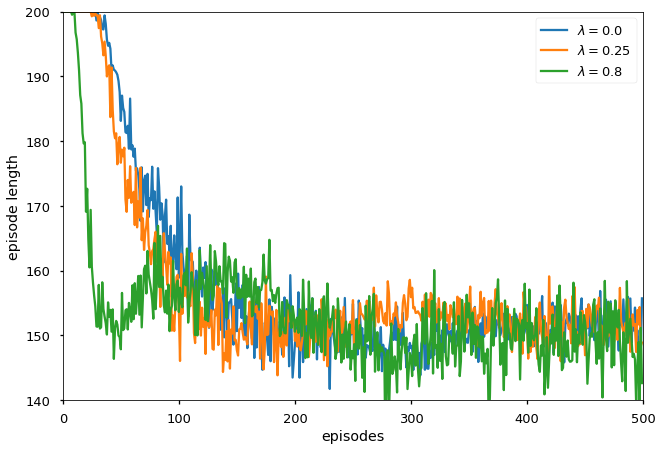

In [10]:
alphas = np.unique(table[:, 0])
lambdas = np.unique(table[:, 1])

for alpha in alphas:
    fig = plt.figure()
    print(f"alpha = {alpha}")
    for _lambda in lambdas: 
        for row in mean_table:
            if row[0] == alpha and row[1] == _lambda and (_lambda.astype(np.float32) == 0.0 or _lambda.astype(np.float32) == 0.25 or _lambda.astype(np.float32) >= 0.8 and _lambda.astype(np.float32) <= 0.85):
                plt.plot(np.squeeze(row[2:].astype(np.float32)), label=fr"$\lambda =${_lambda}")
    plt.xlim([000, 500])
    plt.ylim([140, 200])
    plt.xlabel("episodes")
    plt.ylabel("episode length")
    plt.legend()
    plt.show()

In [8]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf0", RBFSampler(gamma=5.0, n_components = 100)),
    ("rbf1", RBFSampler(gamma=2.0, n_components = 100)),
    ("rbf2", RBFSampler(gamma=1.0, n_components = 100)),
    ("rbf3", RBFSampler(gamma=0.5, n_components = 100)),
    ])
featurizer.fit(scaler.transform(observation_examples))


def featurize(state, action):
    action_vec = np.zeros([3, 1])
    action_vec[action] = 1
    
    win = 0
    if state[0] > 0.5:
        win = 1
    
    try:
        scaled = scaler.transform([state])
    except:
        print(state)
    featurized = featurizer.transform(scaled)
    featurized = np.reshape(featurized, (-1, 1)) # make column vector
    
    featurized = np.append(featurized, np.array([[1]]), axis = 0)
    
    featurized_vec = np.array([])
    featurized_vec = np.expand_dims(featurized_vec, axis=-1)
    for a in action_vec:
        if a == 1:
            featurized_vec = np.append(featurized_vec, featurized, axis = 0)
        elif a == 0:
            featurized_vec = np.append(featurized_vec, np.zeros([len(featurized), 1]), axis = 0)        
    
    return featurized_vec * (1 - win) # append the action to the column vector


def policy(state, w, n, epsilon):
    feat_states = np.zeros([len(w), n, 1])
    q_value = np.zeros([n])

    for i in range(n):    
        feat_state = featurize(state, i)
        feat_states[:, i] = feat_state
        q_value[i] = np.transpose(feat_state) @ w
            
    if epsilon < np.random.rand(1):
        action = np.argmax(q_value)
    else:
        action = random.choice(range(n))
        
    return feat_states[:, action], action

In [14]:
def trueOnline_SARSA(nb_episodes, alpha, _lambda):

    #alpha = 0.01
    gamma = 1
    # _lambda = 0.1 # we call it like that because lambda is a defined command in python
    epsilon = 0.15
    #nb_episodes = 100

    env = gym.make('MountainCar-v0')
    state = env.reset()
    feat_state = featurize(state, 0)
    feat_dims = len(feat_state)

    w = np.zeros(feat_dims)
    w = np.expand_dims(w, axis=-1)

    needed_steps_lambda = []

    k = 0
    for j in tqdm(range(nb_episodes)):
        length = 0

        state = env.reset()
        feat_state, action = policy(state, w, env.action_space.n, epsilon)

        q_old = 0
        z = np.zeros_like(feat_state)

        while True:
            #env.render()
            length += 1

            # STEP
            next_state, reward, done, _ = env.step(action)
            feat_next_state, next_action = policy(next_state, w, env.action_space.n, epsilon)


            # LEARN
            q = np.transpose(w) @ feat_state
            q_prime = np.transpose(w) @ feat_next_state
            delta = reward + gamma * q_prime - q
            z = gamma * _lambda * z + (1 - alpha * gamma * _lambda * np.transpose(feat_state) @ z) * feat_state
            w = w + alpha * (delta + q - q_old) * z - alpha * (q - q_old) * feat_state
            q_old = q_prime


            feat_state = feat_next_state
            state = next_state
            action = next_action

            if done:
                #print(f"Episode: {j}, Length {length}")
                needed_steps_lambda.append(length)
                if j % 10 == 0:
                    # plot_surface_LSPI(w, feat_dims)
                    pass
                break

        env.close()

    return needed_steps_lambda

In [26]:
import csv
from joblib import Parallel, delayed

#head = ["alpha", "lambda", "run", "episode_history"]

#file = open('linear_sarsa_lambda.csv', 'w') 

#with file:
#    writer = csv.writer(file)
#    writer.writerow(head)

nb_episodes = 500
episodes = np.arange(0, nb_episodes, 1)
tries = np.arange(0, 50, 1)

#lambda_step = 0.05
lambdas = np.array([0.8, 0.9, 0.95])# np.arange(0, 0.3 + lambda_step, lambda_step)

#alpha_step0 = 2.5e-5
#alphas0 = np.arange(alpha_step0, 1e-4 + alpha_step0, alpha_step0)
#alpha_step1 = 2.5e-4
#alphas1 = np.arange(alpha_step1, 1e-3 + alpha_step1, alpha_step1)
alphas = [0.01] #np.concatenate((alphas0, alphas1))

for alpha in tqdm(alphas):
    for _lambda in lambdas:
        print("starting")
        a = time.time()
        results = Parallel(n_jobs=6)(delayed(trueOnline_SARSA)(nb_episodes, alpha, _lambda) for run in tries)
        print("ending")
        print(f"took {time.time()-a} seconds")
        
        for run, res in enumerate(results):
            #res = sarsa_lambda(nb_episodes, alpha, _lambda)
            dataseries = np.concatenate(([alpha], [_lambda], [int(run)], res))
            file =  open('linear_sarsa_lambda.csv', 'a')
            with file:
                writer = csv.writer(file)
                writer.writerow(dataseries)
           

starting
ending
took 1145.4475927352905 seconds
starting
ending
took 1179.6022017002106 seconds
starting
ending
took 1287.278193473816 seconds

